<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 9th exercise: <font color="#C70039">Interpretable Machine Learning by means of Partial Dependence (PDP) and Individual Conditional Expectation (ICE) Plots</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Date:   03.12.2023
* Student: Max Hammer
* Immatriculation ID: 11153562

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_partial_dependence_003.png" style="float: center;" width="800">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:

Partial dependence plots (PDP) and individual conditional expectation (ICE) plots can be used to visualize and analyze the interaction between the target response and a set of input features of interest.
Both PDPs [H2009] and ICEs [G2015] assume that the input features of interest are independent from the complement features and this assumption is often violated in practice. Thus, in the case of correlated features, we will create absurd data points to compute the PDP/ICE.

[H2009]
T. Hastie, R. Tibshirani and J. Friedman, The Elements of Statistical Learning, Second Edition, Section 10.13.2, Springer, 2009.

[G2015]
A. Goldstein, A. Kapelner, J. Bleich, and E. Pitkin, “Peeking Inside the Black Box: Visualizing Statistical Learning With Plots of Individual Conditional Expectation” Journal of Computational and Graphical Statistics, 24(1): 44-65, Springer, 2015.

---------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time.
    * try to follow the interpretations by printing out the decision tree and look for the feature patterns that the PDPs indicate.

**PART I**<br>
4. download an interesting data set from Kaggle and do the preprocessing.<br>
5. change the classifier according to the data set. The more blackbox the better.<br>
6. use PDP to identify the most relevant features explaining the target response of the data set.<br> 
7. comment your entire code and your findings.<br>  

**PART II**<br>
8. use the data set and the classifer from steps 4 and 5<br>
9. plot ICE curves with parameter (kind='both')<br>
10. comment your entire code and your findings.<br>  

---------------------------------

# <font color="ce33ff">PART I (Partial Dependence Plots)</font>

## Imports
Import all necessary python utilities.

In [54]:
#make sure you take these packages (in colab too)
#!pip install matplotlib==3.1.1 scikit-learn==0.23.1 PDPbox==0.2.1

In [55]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from matplotlib import pyplot as plt
from pdpbox import pdp, get_example, info_plots

#import warnings 
#warnings.filterwarnings('ignore')

## Load data set

In [56]:
data = pd.read_csv('./data/FIFA/FIFA.Statistics.2018.csv')
data.head(3)

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,...,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,60,6,0,3,3,2,...,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN
2,15-06-2018,Egypt,Uruguay,0,43,8,3,3,2,0,...,2,0,0,No,NaN,Group Stage,No,0,NaN,NaN


In [57]:
# all features are:
print(data.columns.tolist())

['Date', 'Team', 'Opponent', 'Goal Scored', 'Ball Possession %', 'Attempts', 'On-Target', 'Off-Target', 'Blocked', 'Corners', 'Offsides', 'Free Kicks', 'Saves', 'Pass Accuracy %', 'Passes', 'Distance Covered (Kms)', 'Fouls Committed', 'Yellow Card', 'Yellow & Red', 'Red', 'Man of the Match', '1st Goal', 'Round', 'PSO', 'Goals in PSO', 'Own goals', 'Own goal Time']


## Preprocessing


In [58]:
# Convert from string “Yes”/”No” to binary
y = (data['Man of the Match'] == 'Yes') 

feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]

x = data[feature_names]

## Train the classifier

Start with a simple decision tree model.
<font color=red>Note:</font> The calculation of a partial dependence can happen obviously, only after a model has been trained. 

In [59]:
train_x, val_x, train_y, val_y = train_test_split(x, y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(train_x, train_y)

## Partial Dependence Plots (PDP)
#### read the API reference guide for further possibilities 
https://pdpbox.readthedocs.io/en/latest/PDPIsolate.html#pdpbox.pdp.PDPIsolate

In [60]:
# Create the pdp data to be plotted
pdp_goals = pdp.PDPIsolate(model=tree_model, df=val_x, model_features=feature_names, feature='Goal Scored', feature_name='Number of Goals Scored')

# plot the PDP for feature 'Goal Scored'
fig, axes = pdp_goals.plot(
    center=False,
    plot_lines=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method='accurate',
    plot_pts_dist=True,
    to_bins=False,
    show_percentile=False,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params={"pdp_hl": True},
    engine='plotly',
    template='plotly_white')

fig.show()

obtain pred_func from the provided model.


100%|██████████| 6/6 [00:00<00:00, 1190.72it/s]


A few things are worth to be pointed out for interpreting this plot.

The y-axis is interpreted as change in the prediction from what it would be predicted at the baseline or leftmost value.

From this particular graph you can interpret, that scoring one goal substantially increases the chances of winning "Man of The Match." 
But extra goals beyond that show little to no impact on predictions.

In [61]:
# Create the pdp data to be plotted
pdp_dist = pdp.PDPIsolate(model=tree_model, df=val_x, model_features=feature_names, feature='Distance Covered (Kms)', feature_name='Distance covered in km')

# plot the PDP for feature 'Distance Covered (Kms)'
fig, axes = pdp_dist.plot(
    center=False,
    plot_lines=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method='accurate',
    plot_pts_dist=True,
    to_bins=False,
    show_percentile=False,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params={"pdp_hl": True},
    engine='plotly',
    template='plotly_white')

fig.show()

obtain pred_func from the provided model.


100%|██████████| 10/10 [00:00<00:00, 1054.43it/s]


In this PDP plot you will see the ticks on the x-axis as depicting the real data samples.

This PDP plot seems to be too simple to represent reality. 
Maybe that's because the model is so simple. Print the decision tree to compare that finding to the decision tree structure.
For the purpose of 
Let's back up our theory and do the same plot with a Random Forest model.

In [62]:
# Build a new model: Random Forest classifier
rf_model = RandomForestClassifier(random_state=0).fit(train_x, train_y)

In [63]:
# Create the pdp data to be plotted
pdp_dist = pdp.PDPIsolate(model=rf_model, df=val_x, model_features=feature_names, feature='Distance Covered (Kms)', feature_name='Distance covered in km')

# plot the PDP for feature 'Distance Covered (Kms)'
fig, axes = pdp_dist.plot(
    center=False,
    plot_lines=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method='accurate',
    plot_pts_dist=True,
    to_bins=False,
    show_percentile=False,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params={"pdp_hl": True},
    engine='plotly',
    template='plotly_white')

fig.show()

obtain pred_func from the provided model.


100%|██████████| 10/10 [00:00<00:00, 333.63it/s]


<font color=red>Interpretation:</font> 
This model states that it is more likely to win "Man of the Match" if the players run a total of about 100 km during the match. More running leads to lower predictions.
In general, the smoother shape of this curve seems more plausible than the step function of the decision tree model. 
However, this data set is much too small. One should be very careful when interpreting a model.

## 2D Partial Depedence Plot

Now, plotting the PDP for two features can be done by using the **pdp_interact** and **pdp_interact_plot** functions.

First, switch back to the simple decision tree model.

In [64]:
train_x, val_x, train_y, val_y = train_test_split(x, y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(train_x, train_y)

In [65]:
# Similar to previous PDP plot.
# However, use pdp_interact instead of pdp_isolate and pdp_interact_plot instead of pdp_isolate_plot

# plot PDP for the two features
features_to_plot = ['Goal Scored', 'Distance Covered (Kms)']

pdp_goal_distance = pdp.PDPInteract(model=tree_model, df=val_x, model_features=feature_names, features=features_to_plot, feature_names=["Number of Goals Scored", "Distance covered in km"])

fig, axes = pdp_goal_distance.plot(
    plot_type="grid",
    plot_pdp=True,
    to_bins=True,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine='plotly',
    template='plotly_white'
)
fig.show()

obtain pred_func from the provided model.


100%|██████████| 6/6 [00:00<00:00, 870.04it/s]


obtain pred_func from the provided model.


100%|██████████| 10/10 [00:00<00:00, 1222.51it/s]


obtain pred_func from the provided model.


100%|██████████| 60/60 [00:00<00:00, 1199.11it/s]


<font color=red>Interpretation:</font> 
This **2D PDP** shows predictions for any combination of **Goals Scored** and **Distance Covered (Kms)**.

For example, it seems to yield the highest predictions when a team scores at least one (1) goal and they run a total distance close to 100km. 
If the players score 0 goals, the covered distance does not matter. 

Try to see this by tracing through the decision tree with 0 goals!

But distance can impact predictions if the players score goals. 
Make sure you can see this from the 2D PDP. 
Can you find this pattern in the decision tree too?

If you feel motivated to tweak the chart this tutorial ressource might be of value: 
https://github.com/SauceCat/PDPbox/blob/master/tutorials/pdpbox_binary_classification.ipynb

# <font color="ce33ff">PART II (Individual Conditional Expectation)</font>

ICE is also a model-agnostic method that can be applied to any model. 
In fact, it is basically the same concept as PDP but is different in that it displays the marginal effect of feature(s) 
for each instance instead of calculating the average effect in a overall data context as the PDP does. 
Thus, it can understood as the equivalent to a PDP for individual data instances. 
Visually, an ICE plot displays the dependence of the prediction on a feature for each instance separately, 
resulting in one line per instance.

There are multiple packages and libraries that can be used to compute ICE plots. 

The PartialDependenceDisplay function in the sklearn.inspection module, the PyCEBox package and H2O package’s ice_plot function are available.

Let’s take a look at an example in Sklearn’s documentation (https://scikit-learn.org/stable/modules/partial_dependence.html).

## Imports
Import all necessary python utilities.

In [66]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

# make sure you have installed scikit-learn of version > 1.0 
# since the method from_estimator() is not available in previous versions
from sklearn.inspection import PartialDependenceDisplay

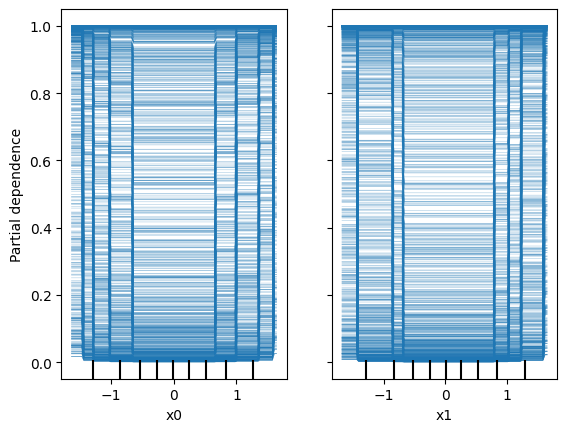

In [67]:
# Read some inbuild data set as part of the Sklearn data sets being offered
# To get more information on the data set please refer to 
''' https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_hastie_10_2.html '''

x, y = make_hastie_10_2(random_state=0) # set a seed with random_state

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(x, y)
features = [0, 1] #features x and y

PartialDependenceDisplay.from_estimator(clf, x, features, kind='individual')

It is evident that, similar to PDPs, ICE curves can be computed only after a model has been trained.

If you specify the parameter kind='both', then a PDP and an ICE curve is plotted in one canvas at the same time. 
This will be meaningful when looking at both, the marginal average effect and marginal individual effects at once!

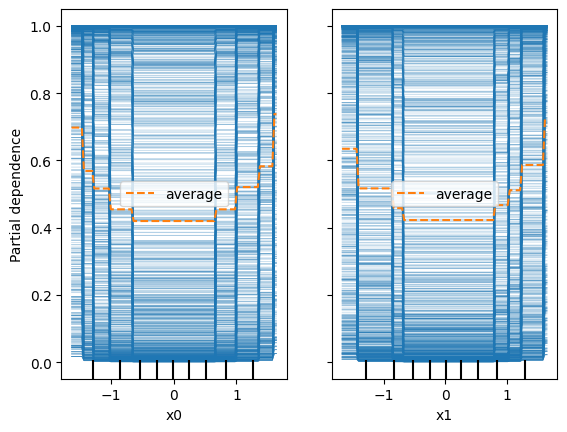

In [68]:
PartialDependenceDisplay.from_estimator(clf, x, features, kind='both')

# Task

In [69]:
# Import iris data set
data = pd.read_csv('./data/coffee/simplified_coffee.csv')

# Preview the data
data.head(3)

,name,roaster,roast,loc_country,origin,100g_USD,rating,review_date,review
0,Ethiopia Shakiso Mormora,Revel Coffee,Medium-Light,United States,Ethiopia,4.70,92,November 2017,"Crisply sweet, cocoa-toned. Lemon blossom, roa..."
1,Ethiopia Suke Quto,Roast House,Medium-Light,United States,Ethiopia,4.19,92,November 2017,"Delicate, sweetly spice-toned. Pink peppercorn..."
2,Ethiopia Gedeb Halo Beriti,Big Creek Coffee Roasters,Medium,United States,Ethiopia,4.85,94,November 2017,"Deeply sweet, subtly pungent. Honey, pear, tan..."


In [70]:
# Preprocess
print(data.columns.tolist())
# Convert origin==Ethiopia from string to binary
y = (data['origin'] == 'Ethiopia')

feature_names = [i for i in data.columns if data[i].dtype in [np.float64, np.int64]]

x = data[feature_names]

# min-max normalize the data
x = (x - x.min())/(x.max() - x.min())

print(feature_names)

['name', 'roaster', 'roast', 'loc_country', 'origin', '100g_USD', 'rating', 'review_date', 'review']
['100g_USD', 'rating']


In [71]:
# Train classifier

train_x, val_x, train_y, val_y = train_test_split(x, y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(train_x, train_y)

In [72]:
# Plot PDP
# Create the pdp data to be plotted
pdp_goals = pdp.PDPIsolate(model=tree_model, df=val_x, model_features=feature_names, feature='rating', feature_name='rating')

# plot the PDP for feature 'Goal Scored'
fig, axes = pdp_goals.plot(
    center=False,
    plot_lines=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method='accurate',
    plot_pts_dist=True,
    to_bins=False,
    show_percentile=False,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params={"pdp_hl": True},
    engine='plotly',
    template='plotly_white')

fig.show()

obtain pred_func from the provided model.


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 1035.89it/s]


Looking at this graph you can see that it seems more likely that when the rating >=94 that it is from ethoipia.

In [73]:
# Plot PDP
# Create the pdp data to be plotted
pdp_goals = pdp.PDPIsolate(model=tree_model, df=val_x, model_features=feature_names, feature='100g_USD', feature_name='Price per 100g')

# plot the PDP for feature 'Goal Scored'
fig, axes = pdp_goals.plot(
    center=False,
    plot_lines=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method='accurate',
    plot_pts_dist=True,
    to_bins=False,
    show_percentile=False,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params={"pdp_hl": True},
    engine='plotly',
    template='plotly_white')

fig.show()

obtain pred_func from the provided model.


100%|██████████| 10/10 [00:00<00:00, 1151.90it/s]


Seems like the model is not very good at predicting the country of origin based on the price. Since the data distribution is very skewed towards the lower end of the price range, the model is not able to learn much from the higher end of the price range.

We try with another model to see if we can achieve better results.

In [74]:
# Build a new model: Random Forest classifier
rf_model = RandomForestClassifier(random_state=0).fit(train_x, train_y)

In [75]:
# Plot PDP
# Create the pdp data to be plotted
pdp_goals = pdp.PDPIsolate(model=rf_model, df=val_x, model_features=feature_names, feature='rating', feature_name='rating')

# plot the PDP for feature 'Goal Scored'
fig, axes = pdp_goals.plot(
    center=False,
    plot_lines=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method='accurate',
    plot_pts_dist=True,
    to_bins=False,
    show_percentile=False,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params={"pdp_hl": True},
    engine='plotly',
    template='plotly_white')

fig.show()

obtain pred_func from the provided model.


100%|██████████| 6/6 [00:00<00:00, 190.54it/s]


This model has similar results to the previous model. It seems like ethiopia is a  likely country of origin for the highest rated coffee beans.

In [76]:
# Plot PDP
# Create the pdp data to be plotted
pdp_goals = pdp.PDPIsolate(model=rf_model, df=val_x, model_features=feature_names, feature='100g_USD', feature_name='Price per 100g')

# plot the PDP for feature 'Goal Scored'
fig, axes = pdp_goals.plot(
    center=False,
    plot_lines=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method='accurate',
    plot_pts_dist=True,
    to_bins=False,
    show_percentile=False,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params={"pdp_hl": True},
    engine='plotly',
    template='plotly_white')

fig.show()

obtain pred_func from the provided model.


100%|██████████| 10/10 [00:00<00:00, 234.40it/s]


In [77]:
# Similar to previous PDP plot.
# However, use pdp_interact instead of pdp_isolate and pdp_interact_plot instead of pdp_isolate_plot

# plot PDP for the two features
features_to_plot = ['rating', '100g_USD']

pdp_goal_distance = pdp.PDPInteract(model=rf_model, df=val_x, model_features=feature_names, features=features_to_plot, feature_names=["Rating", "Price per 100g"])

fig, axes = pdp_goal_distance.plot(
    plot_type="grid",
    plot_pdp=True,
    to_bins=True,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine='plotly',
    template='plotly_white'
)
fig.show()

obtain pred_func from the provided model.


100%|██████████| 6/6 [00:00<00:00, 226.21it/s]


obtain pred_func from the provided model.


100%|██████████| 10/10 [00:00<00:00, 246.15it/s]


obtain pred_func from the provided model.


100%|██████████| 60/60 [00:00<00:00, 304.74it/s]


Looking at the 2D plot the most likely combination for an coffee bean to be from ethiopia is a rating of 95 and a mid ranged  price. Furthermore it seems very unliekly that a coffee is from ethiopia if the rating is below 90.
We can say that rating is a good indicator for classification of ethopian coffee.

# <font color="ce33ff">PART II (Individual Conditional Expectation)</font>

      100g_USD    rating
0     0.034290  0.615385
1     0.030429  0.615385
2     0.035425  0.769231
3     0.037620  0.692308
4     0.028764  0.692308
...        ...       ...
1241  0.034290  0.615385
1242  0.020967  0.692308
1243  0.020967  0.692308
1244  0.034290  0.692308
1245  0.043222  0.769231

[1246 rows x 2 columns]


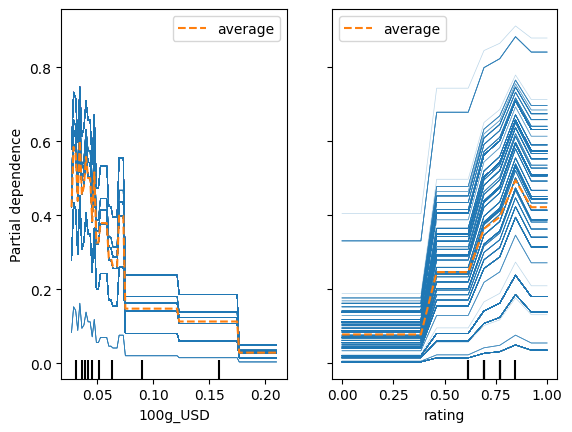

In [78]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

# make sure you have installed scikit-learn of version > 1.0 
# since the method from_estimator() is not available in previous versions
from sklearn.inspection import PartialDependenceDisplay

print(x)

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(x, y)
features = [0, 1] #features x and y

PartialDependenceDisplay.from_estimator(clf, x, features, kind='both')

It seems like we do not have many samples for the higher end of the price range. This is why the model is not able to learn much from the higher end of the price range.
Looking at the rating feature we have no samples for <90.

Still we can see that the model is able to learn that the higher the rating the more likely it is that the coffee is from ethiopia.
The curves are very similar to one another showing no significant difference between the individual samples.